In [289]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
theano.config.exception_verbosity='high'

In [290]:
def all_parity_pairs_with_sequence_labels(nbit):
    X, Y = all_parity_pairs(nbit)
    N, t = X.shape

    # we want every time step to have a label
    Y_t = np.zeros(X.shape, dtype=np.int32)
    for n in xrange(N):
        ones_count = 0
        for i in xrange(t):
            if X[n,i] == 1:
                ones_count += 1
            if ones_count % 2 == 1:
                Y_t[n,i] = 1

    X = X.reshape(N, t, 1).astype(np.float32)
    return X, Y_t

In [291]:
def all_parity_pairs(nbit):
    # total number of samples (Ntotal) will be a multiple of 100
    # why did I make it this way? I don't remember.
    N = 2**nbit
    remainder = 100 - (N % 100)
    Ntotal = N + remainder
    X = np.zeros((Ntotal, nbit))
    Y = np.zeros(Ntotal)
    for ii in xrange(Ntotal):
        i = ii % N
        # now generate the ith sample
        for j in xrange(nbit):
            if i % (2**(j+1)) != 0:
                i -= 2**j
                X[ii,j] = 1
        Y[ii] = X[ii].sum() % 2
    return X, Y


In [292]:
X,y = all_parity_pairs_with_sequence_labels(12)

In [293]:
class rnn:
    def init_weight(self,M1,M2):
        return np.random.randn(M1,M2)/np.sqrt(M1+M2)
    def __init__(self,M):
        self.M = M
    def fit(self,X,Y,learning_rate=10e-1, mu=0.99,show_fig=True,print_period=10,epochs=2,f=T.tanh):
        
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        
        N,T,D = X.shape
        M = self.M
        self.f = f
        
        #initializing the inputs for the computation graphs
        thX = theano.tensor.fmatrix('X')
        thY = theano.tensor.ivector('Y')
        
        K = len(set(Y.flatten()))
        
        #initializing the intermediate shared variables.
        Wx_init = self.init_weight(D,M)
        Wh_init = self.init_weight(M,M)
        bh_init = np.zeros(M)
        Wo_init = self.init_weight(M,K)
        bo_init = np.zeros(K)
        ho_init=  np.zeros(M)
        
        
        self.Wx = theano.shared(Wx_init)
        self.Wh = theano.shared(Wh_init)
        self.bh = theano.shared(bh_init)
        self.Wo = theano.shared(Wo_init)
        self.bo = theano.shared(bo_init)
        self.ho = theano.shared(ho_init)
        
        
        self.params = [self.Wx,self.Wh,self.bh,self.ho,self.Wo,self.bo]
        
        def recurrance(X,h_t):
            h_t = self.f(X.dot(self.Wx)+h_t.dot(self.Wh) + self.bh)
            y_t = theano.tensor.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t,y_t
        
        [h,y],_ = theano.scan(
            fn=recurrance,
            sequences=thX, 
            outputs_info=[self.ho,None],
            n_steps=thX.shape[0]
        )
        
        py_x = y[:,0,:]
        
        #enc = OneHotEncoder(sparse=False,categorical_features='',)
        
        cost = -1*theano.tensor.mean(theano.tensor.log(py_x[theano.tensor.arange(thY.shape[0]),thY]))
        
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        
        grads = theano.tensor.grad(cost,self.params)
        
        updates = [(p,p + mu*dp-learning_rate*g) for p,dp,g in zip(self.params,dparams,grads)       
           ] + [ 
            (dp,mu*dp-learning_rate*g) for dp,g in zip(dparams,grads)
          ]
        
        prediction = np.argmax(py_x,axis=1)
        
        self.train_op = theano.function(
            inputs = [thX,thY],
            outputs = [cost,prediction],
            on_unused_input='warn',
            updates=updates
        )
        self.predict_op = theano.function(
            inputs = [thX],
            outputs = [prediction]
        )
        costs = []
        for i in xrange(epochs):
            cost_ind = 0
            for j in xrange(N):
#                 print "X[j] shape",X[j]
#                 print "shape",X[j].shape
                
#                 print "y[j] shape",Y[j]
#                 print "shape",Y[j].shape
                
                [cost,prediction] = self.train_op(X[j],Y[j])
                cost_ind = cost_ind + cost
#                 print "state value h is",h
#                 print "state value h shape is",h.shape
#                 print "intermediate output is",Y
#                 print "intermediate output Y is",Y.shape
                
            print "Cost is ",cost_ind
            costs.append(cost_ind)
        if show_fig:
            plt.plot(costs)
     

In [294]:
rn = rnn(4)

In [295]:
X,y = all_parity_pairs_with_sequence_labels(12)

Cost is  2848.17751713
Cost is  2827.9186301
Cost is  2826.57790578
Cost is  2825.35877635
Cost is  2823.84188838
Cost is  2821.77565323
Cost is  2818.92855997
Cost is  2815.05086239
Cost is  2809.88078428
Cost is  2803.17354023
Cost is  2794.72497464
Cost is  2784.33497545
Cost is  2771.71809505
Cost is  2756.60654651
Cost is  2739.33636446
Cost is  2721.22204313
Cost is  2703.60011169
Cost is  2686.82975055
Cost is  2670.51427934
Cost is  2654.09330508
Cost is  2637.28995529
Cost is  2620.21552425
Cost is  2602.96726988
Cost is  2585.22256375
Cost is  2566.0567796
Cost is  2543.88307578
Cost is  2516.86568445
Cost is  2483.60505326
Cost is  2446.81551692
Cost is  2412.69620691
Cost is  2382.69833532
Cost is  2355.66492748
Cost is  2330.27373532
Cost is  2305.6871068
Cost is  2281.6341115
Cost is  2258.19830821
Cost is  2235.63737115
Cost is  2214.14539169
Cost is  2193.52854883
Cost is  2172.88035309
Cost is  2150.3271267
Cost is  2123.08321293
Cost is  2089.25712319
Cost is  2051.84

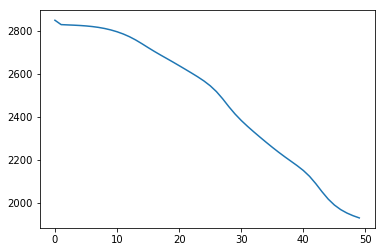

In [296]:
rn.fit(X,y,learning_rate = 10e-5,f = T.nnet.sigmoid,epochs=50)

In [297]:
print b.shape
a[np.arange(a.shape[0]),b]

(3L, 1L, 1L)


array([[[2, 1, 1]],

       [[2, 1, 1]],

       [[2, 1, 1]]])

In [298]:
[(1,2)] + [(2,3)]

[(1, 2), (2, 3)]